# NPE with the `sbi` Toolbox

**Time: ~10 minutes**

In the previous notebooks, we:
1. **Notebook 1**: Implemented rejection ABC from scratch
2. **Notebook 2**: Built a Neural Posterior Estimator (NPE) step-by-step in PyTorch

Now let's see how easy it is to do **production-ready NPE** with the `sbi` package!

The `sbi` package provides:
- Flexible density estimators (normalizing flows, not just Gaussians!)
- Automatic training with sensible defaults
- Built-in diagnostics and validation tools
- GPU support for faster training

**Documentation**: [sbi.readthedocs.io](https://sbi.readthedocs.io/)

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from sbi.inference import NPE
from sbi.analysis import pairplot

from simulators import (
    create_lotka_volterra_prior,
    generate_observed_data,
    lotka_volterra_simulator,
    simulate,
)

/Users/oleksii/local_work/sbi/sbi-hackathon-2026/.venv/lib/python3.12/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


---
## Setup: Same Lotka-Volterra Problem

We'll use the same predator-prey model from Notebook 1, but now with the `sbi` toolbox.

In [2]:
# Setup prior and observed data (same as Notebook 1)
prior = create_lotka_volterra_prior()
x_o, theta_o = generate_observed_data(use_autocorrelation=True)

print(f"Prior: BoxUniform over 4 parameters (α, β, δ, γ)")
print(f"Observed data shape: {x_o.shape} (20 summary statistics)")
print(f"True parameters: α={theta_o[0]:.3f}, β={theta_o[1]:.3f}, δ={theta_o[2]:.3f}, γ={theta_o[3]:.3f}")

Prior: BoxUniform over 4 parameters (α, β, δ, γ)
Observed data shape: torch.Size([1, 20]) (20 summary statistics)
True parameters: α=0.100, β=0.020, δ=0.010, γ=0.100


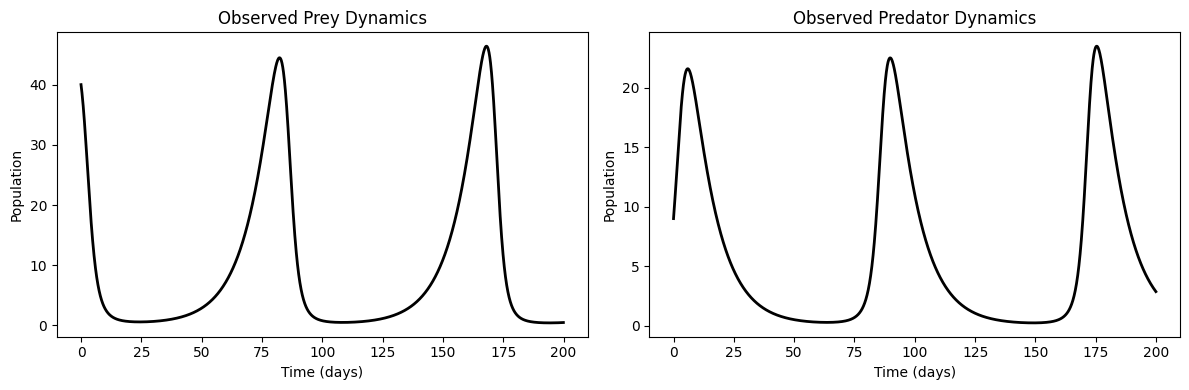

These time series are compressed into 20 summary statistics for inference.


In [3]:
# Visualize the observed time series (ground truth)
# Note: x_o contains summary statistics, so we need simulate() to get the raw time series
time = np.arange(0, 200, 0.1)
ts_observed = simulate(theta_o.numpy())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(time, ts_observed[:, 0], color="k", linewidth=2)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("Observed Prey Dynamics")

ax = axes[1]
ax.plot(time, ts_observed[:, 1], color="k", linewidth=2)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("Observed Predator Dynamics")

plt.tight_layout()
plt.show()

print(f"These time series are compressed into {x_o.shape[1]} summary statistics for inference.")

---
## Think First!

Before we use `sbi`, let's review what NPE does:

**Question 1**: What are the key steps in Neural Posterior Estimation?

**Question 2**: Why is NPE called "amortized" inference?

**Question 3**: What advantage does `sbi` offer over our hand-coded Gaussian NPE from Notebook 2?

<details>
<summary>Click to reveal answers</summary>

1. **NPE Steps**:
   - Sample parameters from prior: θ ~ p(θ)
   - Simulate data for each parameter: x ~ p(x|θ)
   - Train a neural network to approximate the posterior: q(θ|x) ≈ p(θ|x)
   - At inference: just run the network on the observation!

2. **Amortized**: We pay the computational cost once (during training), then inference for any new observation is instant — just a forward pass through the network!

3. **`sbi` advantages**: Uses **normalizing flows** instead of simple Gaussians, which can model complex, multi-modal posteriors with correlations. Also handles training, validation, and diagnostics automatically.

</details>

---
## The NPE Workflow in 4 Steps

The NPE workflow with `sbi` follows 4 core steps:

1. **Generate training data** by sampling parameters from the prior and simulating corresponding data.
2. **Train the neural network** on simulated parameter/data pairs to learn an approximation to the posterior.
3. **Build the posterior estimator** from the trained network.
4. **Sample from the learned posterior** given the observed data.

For detailed code examples and advanced usage, see the [sbi documentation](https://sbi.readthedocs.io/).

### Your Task: Implement the NPE Workflow

Complete the code below to run NPE on the Lotka-Volterra model using `sbi`.

**Hints**:
- Use `prior.sample((n,))` to sample n parameters
- Use `lotka_volterra_simulator(theta, use_autocorrelation=True)` to simulate
- The `NPE` class takes the prior as its first argument

In [16]:
# Step 1: Generate training data
num_simulations = 1_000

# TODO: Sample parameters from the prior
theta = prior.sample((num_simulations, ))

# TODO: Simulate summary statistics for each parameter set
x = lotka_volterra_simulator(theta, use_autocorrelation=True)

print(f"Generated {num_simulations} simulations")
print(f"theta shape: {theta.shape}, x shape: {x.shape}")

Generated 1000 simulations
theta shape: torch.Size([1000, 4]), x shape: torch.Size([1000, 20])


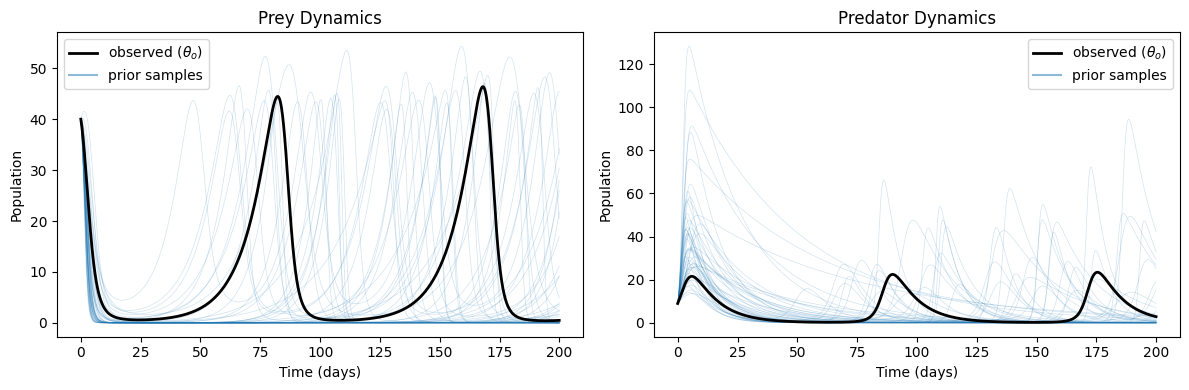

In [17]:
# Visualize time series for a subset of prior samples
n_visualize = 50
ts_prior = [simulate(theta[i].numpy()) for i in range(n_visualize)]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
for ts in ts_prior:
    ax.plot(time, ts[:, 0], color="C0", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label=r"observed ($\theta_o$)")
ax.plot([], [], color="C0", alpha=0.5, label="prior samples")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("Prey Dynamics")
ax.legend()

ax = axes[1]
for ts in ts_prior:
    ax.plot(time, ts[:, 1], color="C0", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 1], color="k", linewidth=2, label=r"observed ($\theta_o$)")
ax.plot([], [], color="C0", alpha=0.5, label="prior samples")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("Predator Dynamics")
ax.legend()

plt.tight_layout()
plt.show()

In [29]:
# Step 2: Train the neural network
# TODO: Create NPE object and train it
npe = NPE(prior)
npe.append_simulations(theta, x).train()

 Neural network successfully converged after 368 epochs.

NFlowsFlow(
  (net): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): PointwiseAffineTransform()
        (1): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=4, out_features=50, bias=True)
            (context_layer): Linear(in_features=20, out_features=50, bias=True)
            (blocks): ModuleList(
              (0-1): 2 x MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (final_layer): MaskedLinear(in_features=50, out_features=8, bias=True)
          )
        )
        (2): RandomPermutation()
        (3): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=4, out_features=50, bias=True)
            (context_layer): Linear(in_featur

In [30]:
# Step 3: Build posterior and sample
# TODO: Build the posterior object
posterior = npe.build_posterior()

In [31]:
# Step 4: Sample from posterior given the observation
# TODO: Draw 10,000 samples from the posterior
samples = posterior.sample((10000,), x=x_o)

  0%|          | 0/10000 [00:00<?, ?it/s]

---
## Visualize the Results

The `sbi` package includes a handy `pairplot` function for visualizing posteriors:

/var/folders/m1/4j5lyx5n0vl0njpx6594d68h0000gp/T/ipykernel_35941/831973876.py:4: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


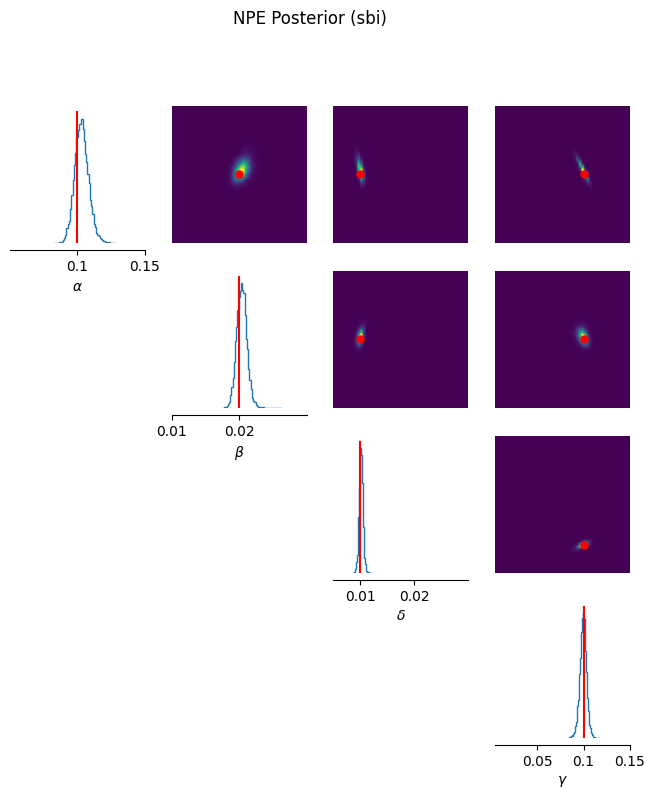

In [32]:
# Visualize posterior with pairplot
param_labels = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]

fig, axes = pairplot(
    samples,
    limits=[[0.05, 0.15], [0.01, 0.03], [0.005, 0.03], [0.005, 0.15]],
    labels=param_labels,
    figsize=(8, 8),
    points=theta_o,  # True parameters
    points_colors="r",
)
plt.suptitle("NPE Posterior (sbi)", y=1.02)
plt.show()

### Compare with Ground Truth

Let's check how well the posterior captures the true parameters:

In [33]:
# Compare posterior statistics with true values
print("Parameter Recovery:")
print("-" * 50)
for i, (name, true_val) in enumerate(zip(["α", "β", "δ", "γ"], theta_o)):
    mean = samples[:, i].mean().item()
    std = samples[:, i].std().item()
    print(f"{name}: True = {true_val:.4f}, Posterior = {mean:.4f} ± {std:.4f}")

Parameter Recovery:
--------------------------------------------------
α: True = 0.1000, Posterior = 0.1030 ± 0.0052
β: True = 0.0200, Posterior = 0.0204 ± 0.0008
δ: True = 0.0100, Posterior = 0.0101 ± 0.0004
γ: True = 0.1000, Posterior = 0.0995 ± 0.0037


---
## Summary

### The NPE Workflow

| Step | Code | What it does |
|------|------|--------------|
| 1. Generate data | `theta = prior.sample((N,))` <br> `x = simulator(theta)` | Sample parameters, run simulations |
| 2. Train | `NPE(prior).append_simulations(theta, x).train()` | Train normalizing flow on (θ, x) pairs |
| 3. Build posterior | `npe.build_posterior()` | Create posterior object for sampling |
| 4. Infer | `posterior.sample((M,), x=x_o)` | Draw samples given observation |

### Key Takeaways

- **`sbi` makes NPE easy**: The entire workflow fits in ~5 lines of code
- **Flexible posteriors**: Uses normalizing flows, not just Gaussians
- **Amortized**: Train once, infer instantly for any new observation
- **Production-ready**: Includes diagnostics, validation, GPU support

### What's Next?

The `sbi` package offers much more:
- **Sequential methods** (SNPE): Focus simulations on regions of interest
- **Other algorithms**: NLE (likelihood estimation), NRE (ratio estimation)
- **Diagnostics**: Simulation-based calibration, coverage tests
- **Advanced features**: Custom networks, embedding nets for high-dimensional data

Explore the documentation: [sbi.readthedocs.io](https://sbi.readthedocs.io/)

---
## Learning Goals

After this notebook, you should be able to:

- Use the `sbi` package to run NPE on a simulator
- Explain the 4-step `sbi` workflow
- Visualize posteriors using `sbi.analysis.pairplot`
- Appreciate how `sbi` simplifies production-ready SBI